# Colab training routine

## Set Up the Environment

In [2]:
! git clone https://github.com/LeonardoDiCaterina/DL.git

Cloning into 'DL'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 529 (delta 49), reused 71 (delta 24), pack-reused 417 (from 1)
Receiving objects: 100% (529/529), 53.51 MiB | 53.04 MiB/s, done.
Resolving deltas: 100% (225/225), done.


## Hardware Testing

In [3]:
from psutil import virtual_memory
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

TensorFlow version: 2.18.0
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Built with CUDA: True
Is GPU available: True


In [6]:
dummy_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])


dummy_input = tf.random.normal((1, 256, 256, 3))
out = dummy_model(dummy_input)
print(out.shape)

(1, 10)


## prepare the direcory for the dataset and preprcess the data

In [7]:
! mkdir /content/DL/data/downloaded_dataset

In [8]:
! gdown --id 1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD --output /content/DL/data/downloaded_dataset/rare_species.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD
From (redirected): https://drive.google.com/uc?id=1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD&confirm=t&uuid=98e52ec8-a974-45ef-884b-e1df522756e6
To: /content/DL/data/downloaded_dataset/rare_species.zip
100% 4.26G/4.26G [00:52<00:00, 81.8MB/s]


In [11]:
! unzip data/downloaded_dataset/rare_species.zip -d data/downloaded_dataset

Output streaming troncato alle ultime 5000 righe.
  inflating: data/downloaded_dataset/chordata_procellariidae/13599615_45511297_eol-full-size-copy.jpg  
  inflating: data/downloaded_dataset/chordata_procellariidae/28929661_1049466_eol-full-size-copy.jpg  
  inflating: data/downloaded_dataset/chordata_procellariidae/20683888_1049466_eol-full-size-copy.jpg  
  inflating: data/downloaded_dataset/chordata_procellariidae/22222316_45511297_eol-full-size-copy.jpg  
   creating: data/downloaded_dataset/arthropoda_theraphosidae/
  inflating: data/downloaded_dataset/arthropoda_theraphosidae/21669750_1181772_eol-full-size-copy.jpg  
  inflating: data/downloaded_dataset/arthropoda_theraphosidae/10785719_1181772_eol-full-size-copy.jpg  
  inflating: data/downloaded_dataset/arthropoda_theraphosidae/21669743_1181772_eol-full-size-copy.jpg  
  inflating: data/downloaded_dataset/arthropoda_theraphosidae/28994684_1181772_eol-full-size-copy.jpg  
  inflating: data/downloaded_dataset/arthropoda_theraphos

In [10]:
%cd DL

/content/DL


copy this in the config file to the `preprocessing_config.py` file
```python
DATA_DIR = 'data/downloaded_dataset'
DEST_DIR = 'data/rearranged'
CSV_PATH = f'{DATA_DIR}/metadata.csv'
N_SPLITS = 5
TEST_SIZE = 0.2 # it's a ratio therefore has to be between 0 and 1
OVERSAMPLE = False
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
LOG_LEVEL = 'INFO'
LABEL_COL = 'family'
OVERCLASS_COL = 'phylum' # set to None if not needed
```


In [13]:
! python -m data_preprocessing.main

2025-05-02 17:32:55.092524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746207175.111161    3415 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746207175.117004    3415 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 17:32:57,704 - __main__ - INFO - Starting preprocessing pipeline
2025-05-02 17:32:57,732 - __main__ - INFO - Loaded metadata with 11983 entries
2025-05-02 17:32:57,733 - data_preprocessing.splitting - INFO - Splitting dataset into train/test and folds
2025-05-02 17:32:57,763 - data_preprocessing.splitting - INFO - Created 5 stratified folds
2025-05-02 17:32:57,763 - __main__ - INFO - Data splitting completed
2025-05-02 17:

# train the model with the whole data

copy this in the config file to the `training/training_config.py` file
```python
NUM_CLASSES = 202
INPUT_SHAPE = (256, 256, 3)
N_EPOCHS_4CV = 5 #number of epochs for cross-validation
N_EPOCHS_4FULL_TRAIN = 10 #number of epochs for test set
```

In [14]:
# load the dataset
from data_preprocessing.public import load_data
train_folds,test_ds = load_data()

Found 2397 files belonging to 202 classes.


Loading folds:   0%|          | 0/5 [00:00<?, ?it/s]

Found 1918 files belonging to 202 classes.


Loading folds:  20%|██        | 1/5 [00:00<00:00,  6.58it/s]

Found 1917 files belonging to 202 classes.


Loading folds:  40%|████      | 2/5 [00:00<00:00,  6.51it/s]

Found 1917 files belonging to 202 classes.


Loading folds:  60%|██████    | 3/5 [00:00<00:00,  6.60it/s]

Found 1917 files belonging to 202 classes.


Loading folds:  80%|████████  | 4/5 [00:00<00:00,  6.63it/s]

Found 1917 files belonging to 202 classes.


Loading folds: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


In [24]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # Changed tf to tensorflow
from tensorflow.keras.callbacks import EarlyStopping
from functools import reduce



In [26]:
from training.model_selection_utils import build_model
from data_preprocessing.public import unify_and_rebatch

def train_best_model(train_folds, test_data,configuration, input_shape = (256, 256, 3) , num_classes = 202 ,
                      epochs=5):

    model_name, freeze_until, dense_layers, learning_rate = configuration

    # Combine all folds into one dataset
    full_train_ds = unify_and_rebatch(train_folds,batch_size= 50)

    # Cache and prefetch the dataset
    full_train_ds = full_train_ds.cache().prefetch(tf.data.AUTOTUNE)

    # Build model with best configuration
    model = build_model(model_name, freeze_until, dense_layers, input_shape, num_classes)

    # Compile with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Optional early stopping for safety
    early_stop = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

    print(f"\nTraining final model with freeze_until={freeze_until}, "
          f"dense_layers={dense_layers}, learning_rate={learning_rate:.2e}")

    # Fit the model with validation data
    history = model.fit(full_train_ds,
                        epochs=epochs,
                        validation_data=test_data,
                        callbacks=[early_stop],
                        verbose=1)

    return model, history


In [27]:
configuration = ('ResNet50', 50, [512], 0.0001)
best_model, best_history = train_best_model(train_folds,test_ds,configuration)


Training final model with freeze_until=50, dense_layers=[512], learning_rate=1.00e-04
Epoch 1/5
    192/Unknown 151s 496ms/step - accuracy: 0.1174 - loss: 4.8542

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/192 ━━━━━━━━━━━━━━━━━━━━ 166s 576ms/step - accuracy: 0.1177 - loss: 4.8512 - val_accuracy: 0.3467 - val_loss: 3.0490
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 419ms/step - accuracy: 0.3960 - loss: 2.8117 - val_accuracy: 0.5002 - val_loss: 2.2268
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 417ms/step - accuracy: 0.5797 - loss: 1.7649 - val_accuracy: 0.5428 - val_loss: 1.9571
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 418ms/step - accuracy: 0.7407 - loss: 1.0560 - val_accuracy: 0.6045 - val_loss: 1.7492
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 416ms/step - accuracy: 0.8349 - loss: 0.6649 - val_accuracy: 0.6249 - val_loss: 1.6450


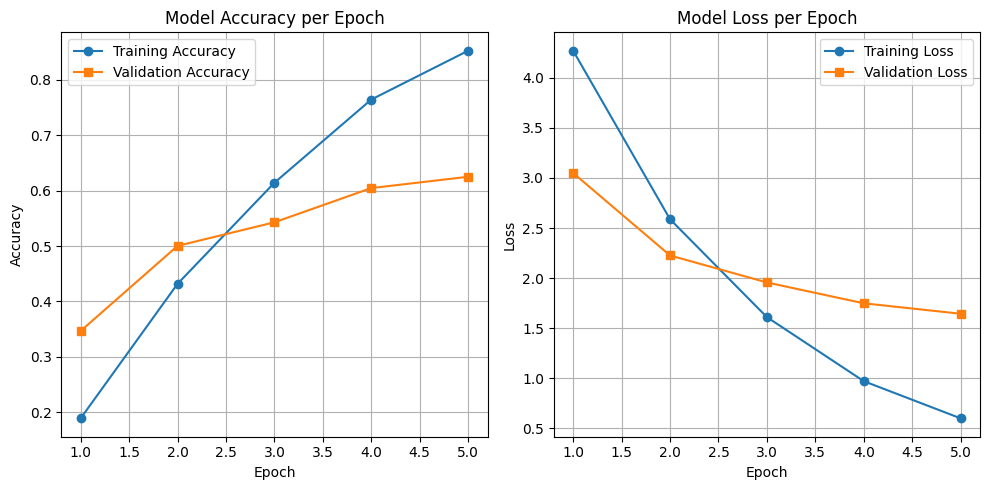

In [28]:
import matplotlib.pyplot as plt
def plot_history(history):
    """
    Plots training and validation accuracy and loss from a Keras history object.

    Args:
        history: A History object returned by model.fit().
    """
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    if acc and loss:
        epochs = range(1, len(acc) + 1)

        # Plot accuracy
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'o-', label='Training Accuracy')
        if val_acc:
            plt.plot(epochs, val_acc, 's-', label='Validation Accuracy')
        plt.title('Model Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'o-', label='Training Loss')
        if val_loss:
            plt.plot(epochs, val_loss, 's-', label='Validation Loss')
        plt.title('Model Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("History object does not contain accuracy or loss data.")

plot_history(best_history)

75


Predicting: 100%|██████████| 75/75 [00:22<00:00,  3.36it/s]


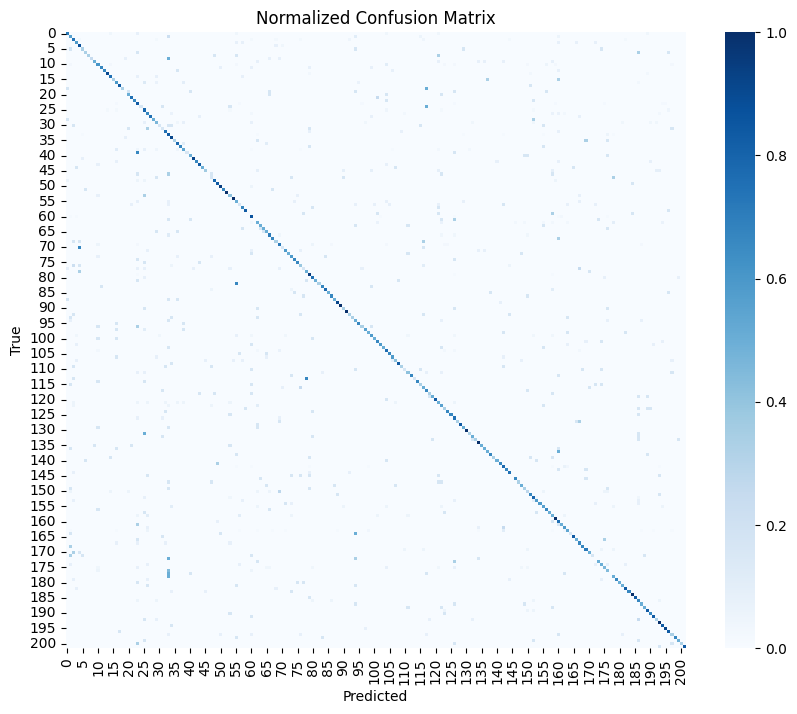

In [30]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tqdm

def plot_confusion_matrix_from_dataset_with_class_names(model, test_dataset):
    """
    Generates and plots a confusion matrix using class names from the dataset.

    Args:
        model: A trained TensorFlow Keras model.
        test_dataset: A TensorFlow PrefetchDataset with a 'class_names' attribute.
    """
    if not hasattr(test_dataset, 'class_names'):
        raise AttributeError("The test_dataset must have a 'class_names' attribute.")

    #class_names = test_dataset.class_names
    y_true = []
    y_pred = []
    print(len(test_dataset))
    # Use tqdm.tqdm to create a progress bar
    for images, labels in tqdm.tqdm(test_dataset, desc="Predicting"):
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=1))
    cm = confusion_matrix(y_true, y_pred)
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_cm, annot=False, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

plot_confusion_matrix_from_dataset_with_class_names(best_model, test_ds)